In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import pandas as pd

import glob 
import random 

from PIL import Image
import cv2

from torch.utils.data import DataLoader

PyTorch Version:  2.0.0+cu118
Torchvision Version:  0.15.1+cu118


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"maximusman","key":"ac0170ab6a010c1b023e6ff8759b8dbb"}'}

In [ ]:
! pip install -q kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                        title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                      Spotify and Youtube                              9MB  2023-03-20 15:43:25           6448        246  1.0              
erdemtaha/cancer-data                                      Cancer Data                                     49KB  2023-03-22 07:57:00           2231         56  1.0              
ulrikthygepedersen/fastfood-nutrition                      Fastfood Nutrition                              12KB  2023-03-21 10:02:41           2352         48  1.0              
lokeshparab/amazon-products-dataset               

In [ ]:
!kaggle datasets download -d denozavrus/paintings-price-prediction

100% 1.07G/1.07G [00:08<00:00, 115MB/s]
100% 1.07G/1.07G [00:08<00:00, 141MB/s]


In [ ]:
! unzip paintings-price-prediction.zip -d paintings-price-prediction

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = 'paintings-price-prediction/images/images/'

# Model
model_name = 'efficientnet_b0'

#input size in the dataset
features_in = 224

# output size in the dataset
features_out = 1

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

train_size = 0.8

In [ ]:
from torch.utils.data import Dataset, TensorDataset, random_split

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, paths, target_path):
        
        self.targets = pd.read_csv(target_path).set_index('image_url')
        self.paths = paths
        

    def __getitem__(self, idx):

        # Read image
        path = self.paths[idx]
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = Image.fromarray(image)

        # Get target
        target = self.get_target(path)
        target = torch.Tensor(target)
        
        return image, target
    
    def get_target(self, path):
        if self.targets.loc[os.path.basename(path)]['price']==0:
            price = min(self.targets['price'][self.targets['price']>0])
        else:
            price = self.targets.loc[os.path.basename(path)]['price']
        return [np.log(price)]

    def __len__(self):
        return len(self.paths)

In [ ]:
paths = glob.glob(data_dir+'*')
init_dataset = ImageDataset(paths, "paintings-price-prediction/paintings_data.csv")
paths[0]

'paintings-price-prediction/images/images/img1270.jpg'

In [ ]:
init_dataset[0]

(<PIL.Image.Image image mode=RGB size=770x534 at 0x7F59ADFCDD30>,
 tensor([7.2442]))

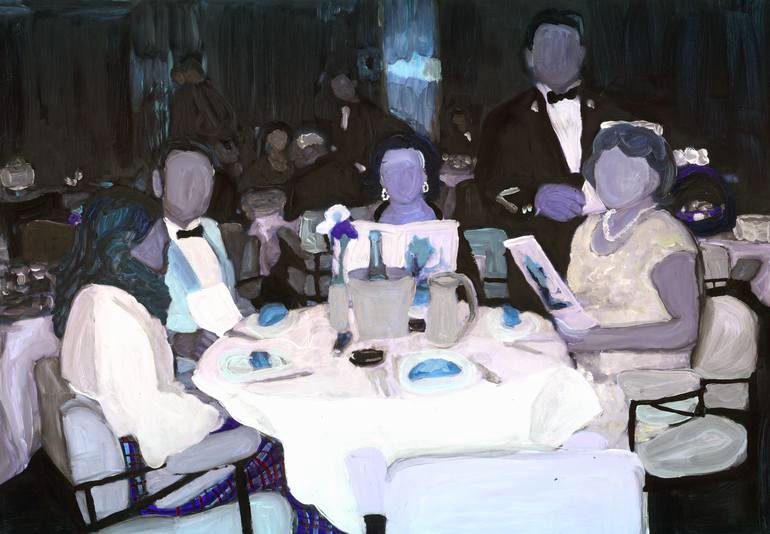

In [ ]:
init_dataset[0][0]

In [ ]:
lengths = [int(len(init_dataset)*0.8), len(init_dataset) - int(len(init_dataset)*0.8)]
train_set, test_set = random_split(init_dataset, lengths)
# Create training and validation datasets
# Data augmentation and normalization for training
print("Initializing Datasets and Dataloaders...")
image_datasets = {
    'train':
    DatasetFromSubset(
        train_set, transform=transforms.Compose([
        transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BICUBIC),
        transforms.CenterCrop(features_in),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])),
    'val': 
    DatasetFromSubset(
        test_set, transform=transforms.Compose([
        transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BICUBIC),
        transforms.CenterCrop(features_in),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=1) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [ ]:
image_datasets['train'][0][0], image_datasets['val'][0][0], image_datasets['train'][0][0].shape

(tensor([[[1.8550, 1.8550, 1.8550,  ..., 1.7352, 1.7352, 1.7523],
          [1.8550, 1.8550, 1.8550,  ..., 1.7352, 1.7352, 1.7523],
          [1.8550, 1.8550, 1.8550,  ..., 1.7352, 1.7352, 1.7523],
          ...,
          [0.5022, 0.6563, 0.5707,  ..., 0.1426, 0.0912, 0.2967],
          [0.5193, 0.6049, 0.4508,  ..., 0.3138, 0.1768, 0.2624],
          [0.4679, 0.5022, 0.5364,  ..., 0.4166, 0.3309, 0.3309]],
 
         [[2.0084, 2.0084, 2.0084,  ..., 1.9034, 1.9034, 1.9209],
          [2.0084, 2.0084, 2.0084,  ..., 1.9034, 1.9034, 1.9209],
          [2.0084, 2.0084, 2.0084,  ..., 1.9034, 1.9034, 1.9209],
          ...,
          [1.0455, 1.2031, 1.1155,  ..., 0.8004, 0.7654, 0.8880],
          [1.0630, 1.1681, 0.9930,  ..., 0.9580, 0.8529, 0.8529],
          [1.0630, 1.0805, 1.0630,  ..., 1.0105, 0.9230, 0.9055]],
 
         [[1.9777, 1.9777, 1.9777,  ..., 1.8034, 1.8034, 1.8208],
          [1.9777, 1.9777, 1.9777,  ..., 1.8034, 1.8034, 1.8208],
          [1.9777, 1.9777, 1.9777,  ...,

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=2):
    since = time.time()

    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    min_loss = 1e9

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.type(torch.float32).cuda()
                labels = labels.type(torch.float32).cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if phase == 'train':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels).type(torch.float32)
                        #print(loss)
                        
                    #preds = np.log(outputs.cpu().detach().numpy())
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(min_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(features_out, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    set_parameter_requires_grad(model, feature_extract)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, features_out, bias=True)
    torch.nn.init.xavier_uniform_(model.classifier[1].weight)
    return model

In [ ]:
model = initialize_model(features_out, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 87.4MB/s]


In [ ]:
# Send the model to GPU
model = model.cuda()

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
#model.parameters() 
# Observe that all parameters are being optimized
optimizer = optim.Adam(params_to_update, lr=1e-3)

In [ ]:
print('Initial weights:',model.features[0][0].weight[0])

Initial weights: tensor([[[ 0.1216,  0.6563,  0.4567],
         [-0.1109, -0.6100, -0.3334],
         [ 0.0280, -0.1031, -0.1032]],

        [[ 0.0636,  1.6552,  1.7436],
         [-0.1365, -1.5367, -1.5937],
         [ 0.0502, -0.1136, -0.1260]],

        [[ 0.0873,  0.3613,  0.2695],
         [-0.1197, -0.2812, -0.2188],
         [ 0.0367, -0.0708, -0.0819]]], device='cuda:0')


In [ ]:
# Setup the loss fxn
criterion = nn.MSELoss()

num_epochs = 5
optimizer = optim.Adam(params_to_update, lr=1e-1)
# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 47.8434
val Loss: 12.2457

Epoch 1/4
----------
train Loss: 6.5085
val Loss: 6.0166

Epoch 2/4
----------
train Loss: 5.1390
val Loss: 5.0584

Epoch 3/4
----------
train Loss: 4.6191
val Loss: 4.9206

Epoch 4/4
----------
train Loss: 4.1455
val Loss: 3.8432

Training complete in 23m 52s
Best val Acc: 3.843173


In [ ]:
torch.save(model.state_dict(), 'model!!!!')

In [ ]:
model = initialize_model(features_out, feature_extract, use_pretrained=True)

model.load_state_dict(torch.load('model'))

model = model.cuda()

In [ ]:
print('Initial weights:',model.features[0][0].weight[0])

Initial weights: tensor([[[ 0.1216,  0.6563,  0.4567],
         [-0.1109, -0.6100, -0.3334],
         [ 0.0280, -0.1031, -0.1032]],

        [[ 0.0636,  1.6552,  1.7436],
         [-0.1365, -1.5367, -1.5937],
         [ 0.0502, -0.1136, -0.1260]],

        [[ 0.0873,  0.3613,  0.2695],
         [-0.1197, -0.2812, -0.2188],
         [ 0.0367, -0.0708, -0.0819]]], device='cuda:0')


In [ ]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
device, available_gpus

(device(type='cuda'), [<torch.cuda.device at 0x7f58cc0b21f0>])

In [ ]:
for param in model.parameters():
    param.requires_grad = True

params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            
# Observe that all parameters are being optimized
optimizer = optim.Adam(params_to_update, lr=1e-3)

In [ ]:
num_epochs = 1
criterion = nn.MSELoss()
#change batch size to the 64 from 256 (full learning)
model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/0
----------
train Loss: 3.3509
val Loss: 3.4102

Training complete in 4m 52s
Best val Acc: 3.410170


In [ ]:
print('Initial weights:',model.features[0][0].weight[0])

Initial weights: tensor([[[ 0.1250,  0.6604,  0.4606],
         [-0.1074, -0.6071, -0.3297],
         [ 0.0330, -0.0978, -0.0968]],

        [[ 0.0699,  1.6629,  1.7506],
         [-0.1293, -1.5295, -1.5866],
         [ 0.0607, -0.1025, -0.1169]],

        [[ 0.0992,  0.3727,  0.2812],
         [-0.1075, -0.2702, -0.2074],
         [ 0.0526, -0.0572, -0.0688]]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [ ]:
num_epochs = 10

model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.4208
val Loss: 1.6359

Epoch 1/9
----------
train Loss: 1.9625
val Loss: 2.3137

Epoch 2/9
----------
train Loss: 1.5723
val Loss: 1.7965

Epoch 3/9
----------
train Loss: 1.2260
val Loss: 1.2796

Epoch 4/9
----------
train Loss: 0.9111
val Loss: 1.3563

Epoch 5/9
----------
train Loss: 0.7153
val Loss: 0.9227

Epoch 6/9
----------
train Loss: 0.5992
val Loss: 0.6722

Epoch 7/9
----------
train Loss: 0.5233
val Loss: 0.5335

Epoch 8/9
----------
train Loss: 0.4659
val Loss: 0.4666

Epoch 9/9
----------
train Loss: 0.4246
val Loss: 0.3087

Training complete in 48m 31s
Best val Acc: 0.308666


In [ ]:
torch.save(model.state_dict(), 'model_the_best')

In [ ]:
#postprocess(model(preprocess(x))) - предварительно модель на cpu иметь

In [96]:
input = cv2.imread('paintings-price-prediction/images/images/img1270.jpg', cv2.IMREAD_COLOR)

In [97]:
def preprocessing(input):
  try:
    image = Image.fromarray(input)
    x = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BICUBIC),
        transforms.CenterCrop(features_in),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])(image)
    x = torch.reshape(x,(1, 3, 224, 224))
  except:
    x = torch.zeros(1, 3, 224, 224)
  return x

def postprocessing(predict):
  try:
    price = np.exp(predict.clip(np.log(40)).detach().numpy())[0][0]
  except:
    price = 1700
  return price

In [98]:
postprocessing(model(preprocessing(input)))

1975.0885

In [100]:
!pip install mlem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.5/218.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5

In [101]:
from mlem.api import save

save(
    model, 
    "model_mlem", 
    preprocess=lambda x: preprocessing(x),
    postprocess=lambda x: {"price": postprocessing(x)},
    sample_data=input,
)

MlemModel(location=Location(path='/content/model_mlem.mlem', project=None, rev=None, uri='file:///content/model_mlem.mlem', project_uri=None, fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f5881ccf1f0>), params={}, artifacts={'preprocess/data.pkl': LocalArtifact(uri='model_mlem/preprocess', size=974, hash='937b6a7701cb0328dfbdd71d089c768c'), 'model/data': LocalArtifact(uri='model_mlem/model', size=16382449, hash='3dbed5bf4ab3257349a269a568a84cb5'), 'postprocess/data.pkl': LocalArtifact(uri='model_mlem/postprocess', size=551, hash='86bd06d54d694961a4c9de7e1d167aa2')}, requirements=Requirements(__root__=[InstallableRequirement(module='torch', version='2.0.0', package_name=None, extra_index='https://download.pytorch.org/whl/cpu', source_url='https://download.pytorch.org/whl/cu118/torch-2.0.0%2Bcu118-cp39-cp39-linux_x86_64.whl', vcs=None, vcs_commit=None), InstallableRequirement(module='numpy', version='1.22.4', package_name=None, extra_index=None, source_url=None, vcs=None,

In [103]:
!zip -r model_mlem.zip model_mlem

  adding: model_mlem/ (stored 0%)
  adding: model_mlem/preprocess (deflated 30%)
  adding: model_mlem/model (deflated 8%)
  adding: model_mlem/postprocess (deflated 26%)
